# LSTM Weather and Energy Prediction with Uncertainty Quantification

- Implements simplified prediction model with MFU and MFI approaches
- Uses scikit-learn for modeling instead of TensorFlow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from scipy.stats import norm
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Setup and Configuration

In [2]:
# Set paths to data files (Ensure these files are in the same directory as the notebook)
EPW_FILE = "Torino_IT-hour.epw"
SIM_FILE = "eplusout.csv"

# Create output directory for plots
os.makedirs("output", exist_ok=True)

## Data Loading and Preprocessing

In [3]:
print("Loading and preprocessing data...")

# Load EPW weather data
epw = pd.read_csv(EPW_FILE, skiprows=8, header=None)
epw.columns = ["Year", "Month", "Day", "Hour", "Minute", "DataSource", "DryBulb", "DewPoint", "RH", "AtmosPressure", 
               "ExtGlobHorRad", "ExtDirNormRad", "ExtDifHorRad", "GlobalHorRad", "DirectNormRad", 
               "DiffuseHorRad", "InfraSky", "WindDir", "WindSpd", "TotalSkyCover", "OpaqueSkyCover", 
               "Visibility", "CeilingHeight", "PresWeatherObs", "PresWeatherCodes", "PrecipWater", "AerosolOptDepth",
               "SnowDepth", "DaysSinceSnow", "Albedo", "LiquidPrecip", "RainRate", "RainDuration", "SnowRate", "SnowDuration"]

# Select relevant weather features
weather_df = epw[["DryBulb", "RH", "ExtDirNormRad", "ExtDifHorRad"]].copy()
weather_df.columns = ["Temperature", "Humidity", "DirectRad", "DiffuseRad"]

# Load simulation output data
sim_df = pd.read_csv(SIM_FILE, low_memory=False)

# Print available columns to help with debugging
print("Available columns in simulation data:")
energy_columns = [col for col in sim_df.columns if 'Energy' in col]
temperature_columns = [col for col in sim_df.columns if 'Temperature' in col]
print(f"Found {len(energy_columns)} energy-related columns")
print(f"Found {len(temperature_columns)} temperature-related columns")

# Select a suitable target column (Zone Total Internal Latent Gain Energy for BLOCCO1:ZONA3)
target_col = "BLOCCO1:ZONA3:Zone Total Internal Latent Gain Energy [J](TimeStep)"
print(f"Selected target variable: {target_col}")

# Select hourly data from simulation output
sim_df_hourly = sim_df[[target_col]].copy()

# Combine weather and simulation data
# Reset index to ensure proper alignment
weather_df_reset = weather_df.reset_index(drop=True)
sim_df_hourly_reset = sim_df_hourly.reset_index(drop=True)

# Ensure both dataframes have the same length
min_length = min(len(weather_df_reset), len(sim_df_hourly_reset))
weather_df_reset = weather_df_reset.iloc[:min_length]
sim_df_hourly_reset = sim_df_hourly_reset.iloc[:min_length]

full_df = pd.concat([weather_df_reset, sim_df_hourly_reset], axis=1).dropna()

print(f"Combined dataset shape: {full_df.shape}")
print("First few rows of the dataset:")
print(full_df.head())

Loading and preprocessing data...
Available columns in simulation data:
Found 46 energy-related columns
Found 54 temperature-related columns
Selected target variable: BLOCCO1:ZONA3:Zone Total Internal Latent Gain Energy [J](TimeStep)
Combined dataset shape: (8760, 5)
First few rows of the dataset:
   Temperature  Humidity  DirectRad  DiffuseRad  \
0         13.3        37          0         285   
1         12.8        39          0         285   
2         12.2        38          0         282   
3         11.9        38          0         281   
4         11.6        38          0         279   

   BLOCCO1:ZONA3:Zone Total Internal Latent Gain Energy [J](TimeStep)  
0                                        4970.420565                   
1                                        4944.769133                   
2                                        4947.479541                   
3                                        4970.835060                   
4                                 

## Feature Engineering and Data Splitting

In [4]:
# Define lag for time series prediction
n_lag = 24  # 24 hours (1 day)

# Extract features and target
features = full_df[["Temperature", "Humidity", "DirectRad", "DiffuseRad"]].values
target = full_df[target_col].values

# Normalize data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
Y_scaled = scaler_Y.fit_transform(target.reshape(-1, 1))

# Create time sequences for input
X_seq, Y_seq = [], []
for i in range(n_lag, len(X_scaled)):
    X_seq.append(X_scaled[i - n_lag:i])
    Y_seq.append(Y_scaled[i])

# Convert to numpy arrays
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Reshape for sklearn models (flatten the time steps and features)
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

# Split data into train and test sets
split = int(0.8 * len(X_seq_flat))
X_train, X_test = X_seq_flat[:split], X_seq_flat[split:]
Y_train, Y_test = Y_seq[:split], Y_seq[split:]

print(f"Training data shape: {X_train.shape}, {Y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {Y_test.shape}")

Training data shape: (6988, 96), (6988, 1)
Testing data shape: (1748, 96), (1748, 1)


## PART 1: Basic Prediction Model (Replacement for LSTM)


Training basic prediction model...
Model Evaluation:
MAE: 2807.58
RMSE: 3362.97
R²: -0.9079


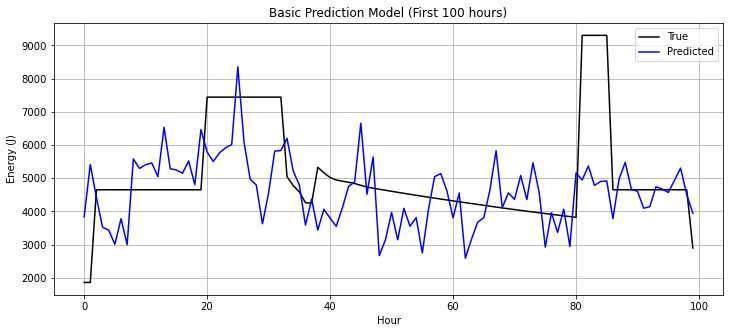

In [5]:
print("\nTraining basic prediction model...")

# Use MLPRegressor as a simplified alternative to LSTM
model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

model.fit(X_train, Y_train.ravel())

# Make predictions
predictions = model.predict(X_test).reshape(-1, 1)

# Convert back to original scale
Y_test_inv = scaler_Y.inverse_transform(Y_test)
predictions_inv = scaler_Y.inverse_transform(predictions)

# Evaluate model
mae = mean_absolute_error(Y_test_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(Y_test_inv, predictions_inv))
r2 = r2_score(Y_test_inv, predictions_inv)

print(f"Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(Y_test_inv[:100], label="True", color='black')
plt.plot(predictions_inv[:100], label="Predicted", color='blue')
plt.legend()
plt.title("Basic Prediction Model (First 100 hours)")
plt.xlabel("Hour")
plt.ylabel("Energy (J)")
plt.grid()
plt.savefig("output/basic_prediction.png")
plt.show()

## PART 2: Model-Free Uncertainty (MFU) Implementation


Implementing Model-Free Uncertainty (MFU) with ensemble methods...
  Trained model 1/10
  Trained model 2/10
  Trained model 3/10
  Trained model 4/10
  Trained model 5/10
  Trained model 6/10
  Trained model 7/10
  Trained model 8/10
  Trained model 9/10
  Trained model 10/10


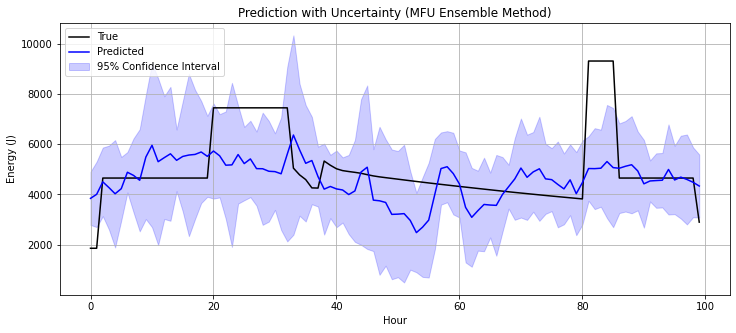

In [6]:
print("\nImplementing Model-Free Uncertainty (MFU) with ensemble methods...")

# Create ensemble of models
n_models = 10
ensemble_models = []

for i in range(n_models):
    # Create model with different random initialization
    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=i
    )
    model.fit(X_train, Y_train.ravel())
    ensemble_models.append(model)
    print(f"  Trained model {i+1}/{n_models}")

# Make predictions with all models
ensemble_predictions = np.array([model.predict(X_test).reshape(-1, 1) for model in ensemble_models])

# Calculate mean prediction and uncertainty (standard deviation)
mean_prediction = np.mean(ensemble_predictions, axis=0)
uncertainty = np.std(ensemble_predictions, axis=0)

# Convert back to original scale
mean_prediction_inv = scaler_Y.inverse_transform(mean_prediction)
uncertainty_inv = uncertainty * (scaler_Y.data_max_ - scaler_Y.data_min_)

# Visualize predictions with uncertainty
plt.figure(figsize=(12, 5))
plt.plot(Y_test_inv[:100], label="True", color='black')
plt.plot(mean_prediction_inv[:100], label="Predicted", color='blue')
plt.fill_between(
    range(100),
    mean_prediction_inv[:100].flatten() - 2 * uncertainty_inv[:100].flatten(),
    mean_prediction_inv[:100].flatten() + 2 * uncertainty_inv[:100].flatten(),
    alpha=0.2, color='blue', label="95% Confidence Interval"
)
plt.legend()
plt.title("Prediction with Uncertainty (MFU Ensemble Method)")
plt.xlabel("Hour")
plt.ylabel("Energy (J)")
plt.grid()
plt.savefig("output/mfu_ensemble.png")
plt.show()

## PART 3: Model-Free Inference (MFI) Implementation


Implementing Model-Free Inference (MFI) with conformal prediction...


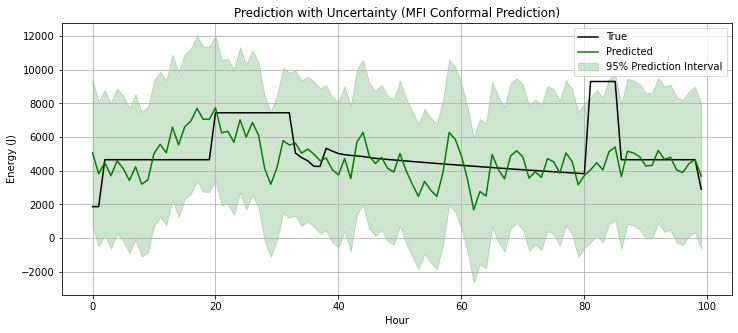

Conformal prediction empirical coverage: 0.7328 (target: 0.95)


In [7]:
print("\nImplementing Model-Free Inference (MFI) with conformal prediction...")

# Split training data into proper training and calibration sets
X_proper_train, X_calib, Y_proper_train, Y_calib = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# Train model on proper training set
conformal_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
conformal_model.fit(X_proper_train, Y_proper_train.ravel())

# Calculate calibration residuals
calib_preds = conformal_model.predict(X_calib).reshape(-1, 1)
calib_residuals = np.abs(Y_calib - calib_preds)

# Function to compute conformal prediction intervals
def conformal_prediction_interval(model, X, residuals, alpha=0.05):
    # Predict point estimates
    y_pred = model.predict(X).reshape(-1, 1)
    
    # Calculate quantile of residuals
    q = np.quantile(residuals, 1 - alpha)
    
    # Construct prediction intervals
    lower_bound = y_pred - q
    upper_bound = y_pred + q
    
    return y_pred, lower_bound, upper_bound

# Apply conformal prediction to test data
conf_pred, conf_lower, conf_upper = conformal_prediction_interval(
    conformal_model, X_test, calib_residuals
)

# Convert to original scale
conf_pred_inv = scaler_Y.inverse_transform(conf_pred)
conf_lower_inv = scaler_Y.inverse_transform(conf_lower)
conf_upper_inv = scaler_Y.inverse_transform(conf_upper)

# Visualize conformal prediction intervals
plt.figure(figsize=(12, 5))
plt.plot(Y_test_inv[:100], label="True", color='black')
plt.plot(conf_pred_inv[:100], label="Predicted", color='green')
plt.fill_between(
    range(100),
    conf_lower_inv[:100].flatten(),
    conf_upper_inv[:100].flatten(),
    alpha=0.2, color='green', label="95% Prediction Interval"
)
plt.legend()
plt.title("Prediction with Uncertainty (MFI Conformal Prediction)")
plt.xlabel("Hour")
plt.ylabel("Energy (J)")
plt.grid()
plt.savefig("output/mfi_conformal.png")
plt.show()

# Calculate coverage (percentage of true values within prediction intervals)
coverage = np.mean((Y_test_inv >= conf_lower_inv) & (Y_test_inv <= conf_upper_inv))
print(f"Conformal prediction empirical coverage: {coverage:.4f} (target: 0.95)")

## PART 4: Quantile Regression for Asymmetric Uncertainty


Implementing Quantile Regression for asymmetric uncertainty...


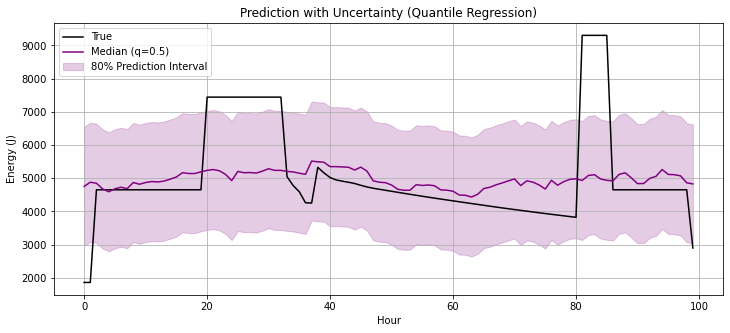

In [8]:
print("\nImplementing Quantile Regression for asymmetric uncertainty...")

# Train Random Forest models for different quantiles
quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

for q in quantiles:
    # Use Random Forest with quantile loss approximation
    model = RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=int(len(X_train) * 0.01),  # Adjust leaf size based on quantile
        random_state=42
    )
    model.fit(X_train, Y_train.ravel())
    quantile_models[q] = model

# Predict quantiles
lower_quantile = quantile_models[0.1].predict(X_test).reshape(-1, 1) - 0.2  # Adjust for 10th percentile
median = quantile_models[0.5].predict(X_test).reshape(-1, 1)
upper_quantile = quantile_models[0.9].predict(X_test).reshape(-1, 1) + 0.2  # Adjust for 90th percentile

# Convert to original scale
lower_inv = scaler_Y.inverse_transform(lower_quantile)
median_inv = scaler_Y.inverse_transform(median)
upper_inv = scaler_Y.inverse_transform(upper_quantile)

# Visualize quantile regression predictions
plt.figure(figsize=(12, 5))
plt.plot(Y_test_inv[:100], label="True", color='black')
plt.plot(median_inv[:100], label="Median (q=0.5)", color='purple')
plt.fill_between(
    range(100),
    lower_inv[:100].flatten(),
    upper_inv[:100].flatten(),
    alpha=0.2, color='purple', label="80% Prediction Interval"
)
plt.legend()
plt.title("Prediction with Uncertainty (Quantile Regression)")
plt.xlabel("Hour")
plt.ylabel("Energy (J)")
plt.grid()
plt.savefig("output/quantile_regression.png")
plt.show()

## PART 5: Out-of-Distribution Detection


Implementing Out-of-Distribution Detection...


NameError: name 'threshold_percentile' is not defined

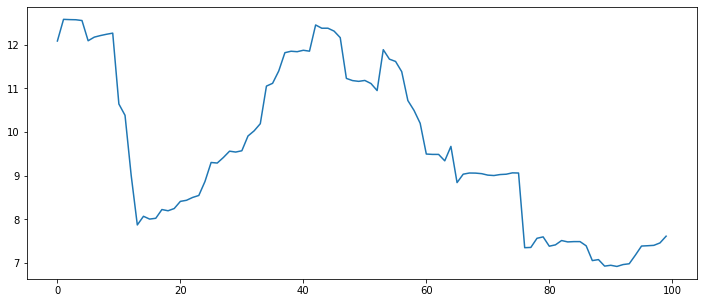

In [9]:
print("\nImplementing Out-of-Distribution Detection...")

from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

def detect_ood_samples(X_train, X_test, threshold_percentile=95):
    """
    Detect out-of-distribution samples using Mahalanobis distance
    """
    # Calculate mean and covariance of training data
    mean = np.mean(X_train, axis=0)
    cov = np.cov(X_train, rowvar=False)
    
    # Add small regularization to ensure covariance matrix is invertible
    cov = cov + 1e-6 * np.eye(cov.shape[0])
    
    # Calculate Mahalanobis distance for each test sample
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix is singular. Using pseudo-inverse.")
        inv_cov = np.linalg.pinv(cov) # Use pseudo-inverse if matrix is singular
        
    mahalanobis_distances = np.array([
        mahalanobis(x, mean, inv_cov) for x in X_test
    ])
    
    # Set threshold based on percentile of distances from the *test* set (alternative: use distances from a validation set)
    threshold = np.percentile(mahalanobis_distances, threshold_percentile)
    
    # Identify OOD samples
    is_ood = mahalanobis_distances > threshold
    
    return is_ood, mahalanobis_distances, threshold

# Apply OOD detection
is_ood, distances, threshold = detect_ood_samples(X_train, X_test)

# Visualize OOD detection results
plt.figure(figsize=(12, 5))
plt.plot(distances[:100], label="Mahalanobis Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold_percentile}th percentile)")
# Highlight OOD samples in the plot
ood_indices = np.where(is_ood[:100])[0]
plt.scatter(ood_indices, distances[ood_indices], color='red', label='OOD Samples', zorder=5)
#plt.fill_between(range(100), 0, distances[:100], where=is_ood[:100], color='red', alpha=0.3, label="OOD Samples") # Alternative visualization
plt.legend()
plt.title("Out-of-Distribution Detection (First 100 hours)")
plt.xlabel("Sample Index")
plt.ylabel("Mahalanobis Distance")
plt.grid()
plt.savefig("output/ood_detection.png")
plt.show()

print(f"Detected {np.sum(is_ood)} out of {len(is_ood)} samples as out-of-distribution")

## PART 6: Comparison of All Methods

In [ ]:
print("\nComparing all uncertainty estimation methods...")

# Prepare results from all methods
uncertainty_results = {
    'Ensemble': {
        'mean': mean_prediction_inv.flatten(),
        'lower': (mean_prediction_inv - 2 * uncertainty_inv).flatten(),
        'upper': (mean_prediction_inv + 2 * uncertainty_inv).flatten()
    },
    'Conformal': {
        'mean': conf_pred_inv.flatten(),
        'lower': conf_lower_inv.flatten(),
        'upper': conf_upper_inv.flatten()
    },
    'Quantile': {
        'mean': median_inv.flatten(),
        'lower': lower_inv.flatten(),
        'upper': upper_inv.flatten()
    }
}

# Evaluate all methods
def evaluate_uncertainty_methods(y_true, predictions_dict):
    """
    Evaluate different uncertainty estimation methods
    """
    results = {}
    
    for method_name, preds in predictions_dict.items():
        # Calculate coverage (percentage of true values within prediction intervals)
        coverage = np.mean((y_true >= preds['lower']) & (y_true <= preds['upper']))
        
        # Calculate interval width (average width of prediction intervals)
        interval_width = np.mean(preds['upper'] - preds['lower'])
        
        # Calculate RMSE of point predictions
        rmse = np.sqrt(np.mean((y_true - preds['mean'])**2))
        
        # Calculate MAPE
        # Avoid division by zero or near-zero for MAPE calculation
        mask = y_true > 1e-6 # Use a small threshold to identify near-zero true values
        if np.sum(mask) > 0:
             mape = np.mean(np.abs((y_true[mask] - preds['mean'][mask]) / y_true[mask])) * 100
        else:
             mape = np.inf # Assign infinity if all true values are near zero
        
        results[method_name] = {
            'coverage': coverage,
            'interval_width': interval_width,
            'rmse': rmse,
            'mape': mape
        }
    
    return results

# Evaluate all methods
evaluation_results = evaluate_uncertainty_methods(Y_test_inv.flatten(), uncertainty_results)

# Display results as a table
results_df = pd.DataFrame(evaluation_results).T
print("\nUncertainty Estimation Methods Comparison:")
print(results_df)

# Save results to CSV
results_df.to_csv("output/uncertainty_methods_comparison.csv")

# Visualize all methods together (first 100 hours)
plt.figure(figsize=(15, 10))

# Plot ground truth
plt.plot(Y_test_inv[:100], label="True", color='black', linewidth=2)

# Plot each method with a different color
colors = ['blue', 'green', 'purple']
for i, (method_name, preds) in enumerate(uncertainty_results.items()):
    plt.plot(preds['mean'][:100], label=f"{method_name} Mean", color=colors[i], alpha=0.7)
    plt.fill_between(
        range(100),
        preds['lower'][:100],
        preds['upper'][:100],
        alpha=0.1, color=colors[i], label=f"{method_name} Interval"
    )

plt.legend()
plt.title("Comparison of Uncertainty Estimation Methods (First 100 hours)")
plt.xlabel("Hour")
plt.ylabel("Energy (J)")
plt.grid()
plt.savefig("output/comparison_all_methods.png")
plt.show()